In [19]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.stats import multivariate_normal
import math
import pandas as pd
plt.style.use('seaborn')
COLOR_LIST = ['red','blue','yellow','green']
config = {
    'k':3,
    'n':200,
    'dim':2,
    'mus':np.array([
        [1,3], [7,8], [8,4]
    ]),
    'sigmas':np.array([
        [[1,0],[0,2]], [[3,0],[0,2]], [[3,0],[0,1]]
    ])
}

In [20]:
def gen_self_data(k, n, dim, mus, sigmas):
    data = np.zeros((k, n, dim))
    for i in range(k):
        data[i] = np.random.multivariate_normal(mus[i], sigmas[i], n)
    data_ = np.zeros((k * n, dim))
    for i in range(k):
        data_[i * n:(i + 1) * n] = data[i]
    return data_

In [21]:
def kmeans(data, K, N, dim):
    classes = np.zeros((N, dim+1)) # classes array
    classes[:,0:dim] = data[:,:]
    # center is the cluster center, it has K classes
    # use a random value to initialize the K centers
    center = np.zeros((K, dim))
    for i in range(K):
        center[i,:] = data[np.random.randint(0, high=N),:]
    # K-means
    while True:
        distance = np.zeros(K) # in each iterate distance stores the distance between each data and the present cluster center
        num = np.zeros(K) # num stores how many data in each class
        new_center = np.zeros((K,dim)) # new cluster center
        # classify Expectation
        for i in range(N):
            for j in range(K):
                distance[j] = np.linalg.norm(data[i,:] - center[j,:]) # calculate the Eculidean distance between data and present center
            arg = np.argmin(distance) # the index of the min of distance
            classes[i,dim] = arg; # tag the data with class

        k = 0 # counter
        # update the new center Maximize
        for i in range(N):
            if classes[i,dim] >= K:
                print('There may be a wrong class: %d'%(K))
            else:
                c = int(classes[i,dim])
                new_center[c,:] = new_center[c,:] + classes[i,:dim]
                num[c] += 1
        for i in range(K):
            if num[i] != 0:
                new_center[i,:] /= num[i]
            distance_bias = np.linalg.norm(new_center[i,:] - center[i,:])
            print('distance bias:', distance_bias)
            if distance_bias < 1e-9:
                k += 1
                print('%d groups converged'%(k))
        # when K classes all converge then the progress is done
        if k == K:
            break
        else:
            center = new_center # update center, next iterate
    return classes

In [22]:
def kmeans_self():
    data = gen_self_data(config['k'], config['n'], config['dim'], config['mus'], config['sigmas'])
    K = 3
    N = np.size(data, axis=0)
    dim = 2
    classes = kmeans(data, K, N, dim)
    # scatter
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for i in range(N):
        if classes[i,dim] == 0:
            ax.scatter(classes[i,0], classes[i,1], alpha=0.7, c='blue', marker='.')
        elif classes[i,dim] == 1:
            ax.scatter(classes[i,0], classes[i,1], alpha=0.7, c='green', marker='.')
        elif classes[i,dim] == 2:
            ax.scatter(classes[i,0], classes[i,1], alpha=0.7, c='red', marker='.')
        elif classes[i,dim] == 3:
            ax.scatter(classes[i,0], classes[i,1], alpha=0.7, c='yellow', marker='.')
        elif classes[i,dim] == 4:
            ax.scatter(classes[i,0], classes[i,1], alpha=0.7, c='magenta', marker='.')
    plt.show()

In [23]:
def e_step(data, mus, sigmas, pis, N, K, dim):
    gammas = np.zeros((N, K))
    for n in range(N):
        marginal_prob = 0
        for j in range(K):
            marginal_prob += pis[j] * multivariate_normal.pdf(data[n], mean=mus[j], cov=sigmas[j])
        for j in range(K):
            gammas[n,j] = pis[j] * multivariate_normal.pdf(data[n], mean=mus[j], cov=sigmas[j]) / marginal_prob
    return gammas      

In [24]:
def m_step(data, gammas, mus, N, K, dim):
    mus_ = np.zeros((K, dim))
    sigmas_ = np.zeros((K, dim, dim))
    pis_ = np.zeros(K)
    for k in range(K):
        nk = 0
        for n in range(N):
            nk += gammas[n,k]
        mu_temp = np.zeros(dim)
        for n in range(N):
            mu_temp += gammas[n,k] * data[n]
        mus_[k] = mu_temp / nk
        
        sigma_temp = np.zeros(dim)
        for n in range(N):
            dis = data[n] - mus[k] # one-dimension array can not be transposed
            sigma_temp += dis**2 * gammas[n,k]
        sigma_temp_ = np.eye(dim)
        sigma_temp_[0,0] = sigma_temp[0]
        sigma_temp_[1,1] = sigma_temp[1]
        sigmas_[k] = sigma_temp_ / nk
        
        pis_[k] = nk / N
    return mus_, sigmas_, pis_       
        

In [25]:
def log_likelihood(data, mus, sigmas, pis, N, K, dim):
    l = 0
    for n in range(N):
        temp = 0
        for k in range(K):
            temp += pis[k] * multivariate_normal.pdf(data[n], mean=mus[k], cov=sigmas[k])
        l += math.log(temp)
    return l    

In [26]:
def show_gmm_result(data, mus, sigmas, classes, real_ce):
    fig = plt.figure()
    ax = plt.subplot()
    K = np.size(mus, 0)
    N = np.size(data, 0)
    for i in range(K):
        ellipse = Ellipse(
            xy=mus[i], width=3*sigmas[i,0,0], height=3*sigmas[i,1,1], edgecolor=COLOR_LIST[i], lw=2, fill=False)
        ax.add_patch(ellipse)
    if real_ce:
        for i in range(K):
            ellipse = Ellipse(
                xy=config['mus'][i], width=3*config['sigmas'][i,0,0], height=3*config['sigmas'][i,1,1], color=COLOR_LIST[i], alpha=0.2)
            ax.add_patch(ellipse)
    for i in range(N):
        plt.scatter(data[i,0], data[i,1], marker='.', color=COLOR_LIST[int(classes[i])])
#     plt.scatter(data[:,0], data[:,1], marker='.', color=COLOR_LIST[classes])
    plt.show()

In [27]:
def gmm_self():
    data = gen_self_data(config['k'], config['n'], config['dim'], config['mus'], config['sigmas'])
    # print(data)
    N = np.size(data, axis=0)
    K = 3
    dim = 2
    mus = np.array([
        [3,3], [4,4], [5,5]
    ])
    sigmas = np.array([
        [[1,0],[0,1]]
    ] * K)
    pis = np.array([1 / K] * K)
    epoch = 100
    eps = 1e-3
    
    classes = np.zeros(N)
    for i in range(epoch):
        old_loss = log_likelihood(data, mus,sigmas, pis, N, K, dim)
        gammas = e_step(data, mus, sigmas, pis, N, K, dim)
        mus, sigmas, pis = m_step(data, gammas, mus, N, K, dim)
        new_loss = log_likelihood(data, mus,sigmas, pis, N, K, dim)
        if i % 10 == 0:
            print(i, new_loss)
            argmaxs = np.argmax(gammas, axis=1)
            for ii in range(N):
                classes[ii] = argmaxs[ii]
            show_gmm_result(data, mus, sigmas, classes, False)
        if (abs(new_loss - old_loss) < eps):
            break
    argmaxs = np.argmax(gammas, axis=1)
    for ii in range(N):
        classes[ii] = argmaxs[ii]
    show_gmm_result(data, mus, sigmas, classes, True)

In [28]:
def gen_seeds_data(file_name):
    df = pd.read_csv(file_name)
    data = df.values
    return data

In [29]:
def uci():
#     data = frog_gen_data('./Frogs_MFCCs.csv')
    data = gen_seeds_data('./seeds_dataset.csv')
    labels = data[:,-1]
    np.delete(data, -1, axis=1)
    N = np.size(data, axis=0)
    dim = np.size(data, axis=1)
    K = 3
    classes = kmeans(data, K, N, dim)
    mus = np.array([
        [0] * dim
    ] * K)
    sigmas = np.array([
        np.eye(dim) 
    ] * K)
    temp = np.array([
        [0] * dim
    ] * K)
    temp_counts = np.array([0] * K)
    for i in range(N):
        c = int(classes[i,-1])
        temp_counts[c] += 1
        for j in range(dim):
            temp[c,j] += classes[i,j]
    for i in range(K):
        for j in range(dim):
            mus[i,j] = temp[i,j] / temp_counts[i]
    for i in range(K):
#         c = int(temp_counts[i])
        for j in range(dim):
            for k in range(N):
                if classes[i,-1] == i:
                    sigmas[i,j,j] += pow((classes[i,j] - mus[i,j]), 2)
            sigmas[i,j,j] /= temp_counts[i]
    pis = np.array([1 / K] * K)
    epoch = 100
    eps = 1e-3
    gmm_classes = np.zeros(N)
    for i in range(epoch):
        old_loss = log_likelihood(data, mus,sigmas, pis, N, K, dim)
        gammas = e_step(data, mus, sigmas, pis, N, K, dim)
        mus, sigmas, pis = m_step(data, gammas, mus, N, K, dim)
        new_loss = log_likelihood(data, mus,sigmas, pis, N, K, dim)
        if i % 10 == 0:
            print(i, new_loss)
            argmaxs = np.argmax(gammas, axis=1)
            for ii in range(N):
                classes[ii] = argmaxs[ii]
        if (abs(new_loss - old_loss) < eps):
            break
    argmaxs = np.argmax(gammas, axis=1)
    for ii in range(N):
        gmm_classes[ii] = argmaxs[ii]
    classes_count = np.zeros(K)
    for i in range(N):
        classes_count[int(gmm_classes[i])] += 1
    print(classes_count)

distance bias: 3.083324312796322
distance bias: 2.972872294784163
distance bias: 0.39381867341463334
distance bias: 0.9704027729129306
distance bias: 1.6252317891992243
distance bias: 0.7972332267189581
distance bias: 0.6401858744851695
distance bias: 1.9718213279065842
distance bias: 0.6494934395673909
distance bias: 0.6028800089308306
distance bias: 0.9922104872872277
distance bias: 0.28004531054930387
distance bias: 1.1796145340363111
distance bias: 0.2886885356230116
distance bias: 0.06191595338758368
distance bias: 1.1163478530637279
distance bias: 0.09693196578158009
distance bias: 0.33583719948663376
distance bias: 1.1101375155934743
distance bias: 0.06308340360750482
distance bias: 0.8108652292660083
distance bias: 0.4277347404588608
distance bias: 0.01617850862080447
distance bias: 0.585744619426924
distance bias: 0.12618076253570384
distance bias: 0.03343857130709641
distance bias: 0.1324460281563676
distance bias: 0.06425522480472237
distance bias: 0.0
1 groups converged
dis

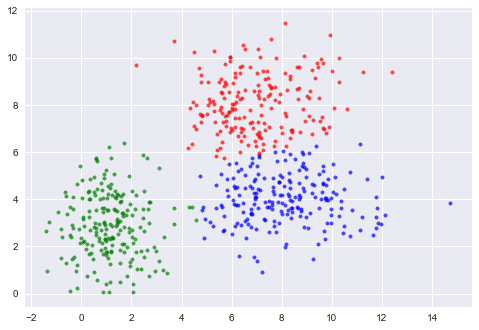

In [30]:
kmeans_self()

0 -2877.3663996465784


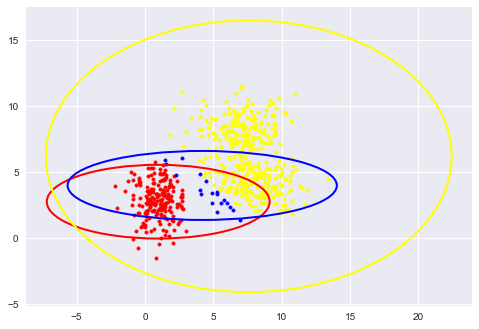

10 -2682.532886407031


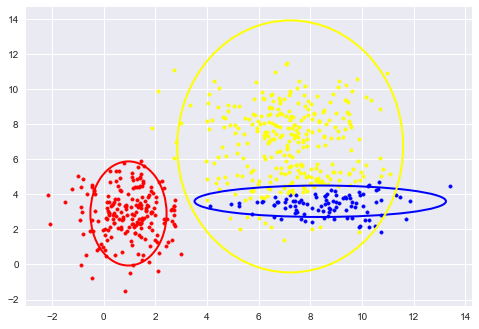

20 -2667.972207762223


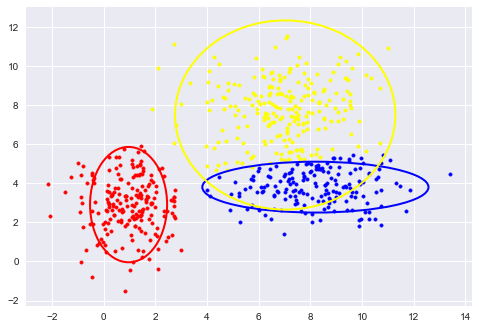

30 -2661.6199175566203


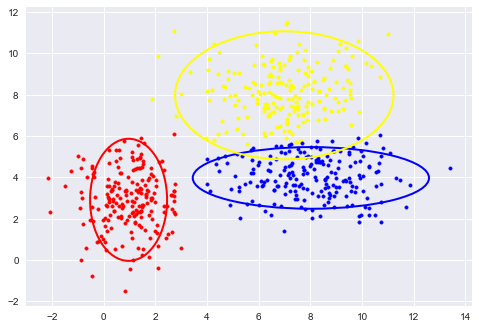

40 -2660.8746225441946


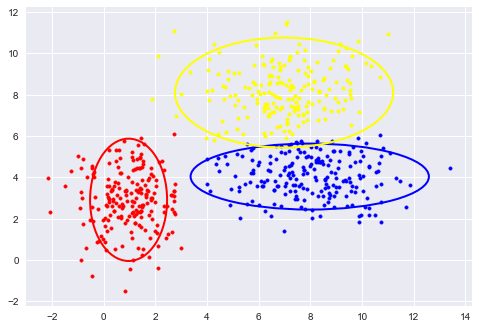

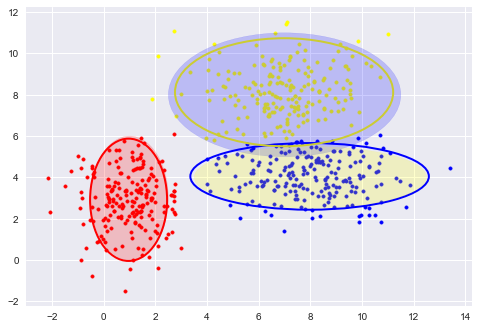

In [31]:
gmm_self()

In [32]:
uci()

distance bias: 0.8217318680446959
distance bias: 0.9308262798579227
distance bias: 1.2717002187885862
distance bias: 0.8480798919941978
distance bias: 0.1637473971976366
distance bias: 1.3268732183141505
distance bias: 0.45564950396648163
distance bias: 0.5566088002629445
distance bias: 0.6643525920283189
distance bias: 0.12594429368098323
distance bias: 0.2026175820387384
distance bias: 0.3086453453165971
distance bias: 0.07944495115512543
distance bias: 0.15647780583361648
distance bias: 0.22470875878830027
distance bias: 0.0
1 groups converged
distance bias: 0.06218726955475801
distance bias: 0.059648809672817944
distance bias: 0.0
1 groups converged
distance bias: 0.0
2 groups converged
distance bias: 0.0
3 groups converged
0 -7190.317449853984
10 -9533.006152887352
20 -9147.862208694027
30 -9129.631863621678
[71. 65. 73.]
